# <center> Analysis of COVID19 Trends for NYC</center>
#### <center>  Project Author: Riddhisha Prabhu </center> 

### <center> Project Summary </center> 

This independent research study utilizes CDC.gov data to explore the spread and impact of COVID-19 through NYC. Some of the questions asked in this study are how and when COVID-19 spread through the city, how the different variants impacted us and what was the impact of the lockdowns, reopenings and vaccinations on the spread of the vaccine. Further, the study also explores if there are any commonalities in the health conditions associated with COVID related deaths. 

This study utilizes three [CDC](https://data.cdc.gov/) datasets:

   (1) CasesandDeaths.csv: This dataset shows the new cases and new deaths on a daily basis for the US. The dataset covers timeperiods Jan 2020 through Sep 2022. Further details are available [here](https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36)

   (2) Vaccinations.csv: This dataset shows the vaccine administation rates across various states/counties in the US. The dataset covers timeperiods Dec 2020 through Sep 2022. Further details are available [here](https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh)
   
   (3) Conditions.csv: This dataset shows health conditions and contributing causes that were mentioned in conjunction with deaths involving COVID-19. The dataset covers timeperiods Jan 2020 through Sep 2022. Further details are available [here](https://data.cdc.gov/NCHS/Conditions-Contributing-to-COVID-19-Deaths-by-Stat/hk9y-quqm)




### <center> MODULE 1: New Cases and Trends</center> 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
##Dataset 1: New cases and deaths

cases_deaths_df = pd.read_csv("CasesandDeaths.csv", parse_dates = [0])
cases_deaths_df.columns




##Data cleaning to create NYC subset
cases_deaths_df = cases_deaths_df[cases_deaths_df["state"] == "NYC"]
cases_deaths_df.drop(['state', 'conf_cases', 'prob_cases', 'pnew_case', 'conf_death', 'prob_death', 'pnew_death', 
  'created_at', 'consent_cases', 'consent_deaths'], axis = 1, inplace = True)


cases_deaths_df.sort_values("submission_date", inplace = True)
cases_deaths_df["YYYYMM"] = cases_deaths_df["submission_date"].apply(lambda x:x.strftime("%Y%m"))
cases_deaths_df = cases_deaths_df[cases_deaths_df["YYYYMM"] != "202210"]

cases_deaths_df.head()




##Aggregating to monthly level - New cases and deaths 
cd_monthly_df = cases_deaths_df.groupby("YYYYMM").agg({"tot_cases" : np.max, 
                                      "new_case" : np.sum,
                                      "tot_death" : np.max,
                                      "new_death" : np.sum})
cd_monthly_df.head()

,tot_cases,new_case,tot_death,new_death
YYYYMM,,,,
202001,0,0,0,0
202002,0,0,0,0
202003,53869,53869,1744,1744
202004,174169,120300,18478,16734
202005,206857,32688,22131,3653


In [3]:
##Dataset 2: Vaccination stats
##for this project we we consider individuals with atleast one vaccine dose as "vaccinated"

vacc_df = pd.read_csv("Vaccinations.csv", parse_dates = [0])

vacc_ny_df = vacc_df[(vacc_df["Recip_State"] == "NY") & (vacc_df["Recip_County"] == "New York County")]
vacc_ny_df.sort_values("Date", inplace = True)
vacc_ny_df = vacc_ny_df[["Date","Administered_Dose1_Recip","Administered_Dose1_Pop_Pct"]]
vacc_ny_df["YYYYMM"] = vacc_ny_df["Date"].apply(lambda x: x.strftime("%Y%m")) 

# vacc_ny_df.head()



##Aggregating to monthly level - vaccinations (atleast one dose)
vacc_monthly_df = vacc_ny_df.groupby("YYYYMM").agg({"Administered_Dose1_Recip": np.max,
                                                    "Administered_Dose1_Pop_Pct": np.max}).round(2).reset_index()

vacc_monthly_df.head()

,YYYYMM,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct
0,202012,22924.0,1.4
1,202101,159303.0,9.8
2,202102,276530.0,17.0
3,202103,586133.0,36.0
4,202104,917746.0,56.3


In [4]:
merged_df =  pd.merge(cd_monthly_df, vacc_monthly_df, how= "left", left_on = "YYYYMM",  right_on = "YYYYMM")

merged_df.head()

,YYYYMM,tot_cases,new_case,tot_death,new_death,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct
0,202001,0,0,0,0,NaN,NaN
1,202002,0,0,0,0,NaN,NaN
2,202003,53869,53869,1744,1744,NaN,NaN
3,202004,174169,120300,18478,16734,NaN,NaN
4,202005,206857,32688,22131,3653,NaN,NaN


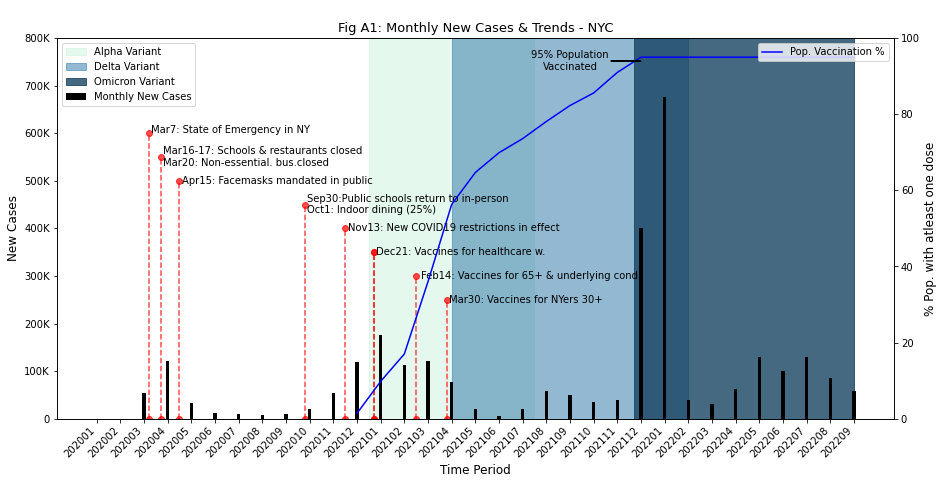

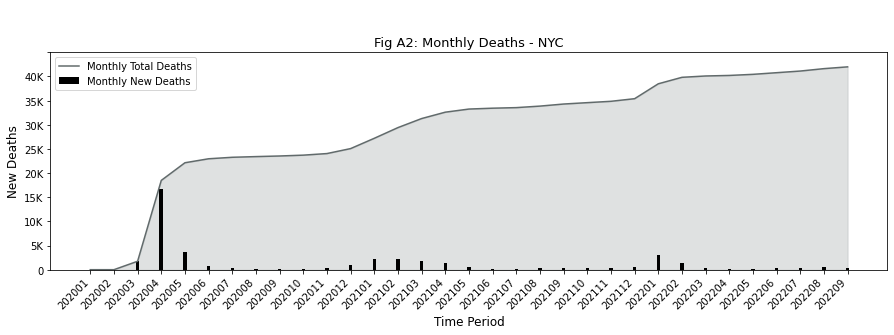

In [5]:
plt.figure(figsize = (15,7));


plt.bar(merged_df.index, merged_df["new_case"], width = 0.15, label = "Monthly New Cases", 
        color = "black", zorder = 3);

plt.axvspan(11.5,18.5, color = "#ABEBC6", alpha = 0.3, label ="Alpha Variant");
plt.axvspan(15,25, color = "#2874A6", alpha = 0.5, label ="Delta Variant");
plt.axvspan(22.7,32, color = "#154360", alpha = 0.8, label ="Omicron Variant");


plt.plot([2.2,2.2],[0,600000], color = "red", marker = "o", alpha = 0.7, linestyle = "--");
plt.text(2.3, 600000,"Mar7: State of Emergency in NY", fontsize = 10);
plt.plot([2.7,2.7],[0,550000], color = "red", marker = "o", alpha = 0.7, linestyle = "--");
plt.text(2.8, 550000,"""Mar16-17: Schools & restaurants closed
Mar20: Non-essential. bus.closed""", fontsize = 10, va ="center");
plt.plot([3.5,3.5],[0,500000], color = "red", marker = "o", alpha = 0.7, linestyle = "--");
plt.text(3.6, 500000,"Apr15: Facemasks mandated in public", fontsize = 10, va ="center");
plt.plot([8.8,8.8],[0,450000], color = "red", marker = "o", alpha = 0.7, linestyle = "--");
plt.text(8.9, 450000,"""Sep30:Public schools return to in-person
Oct1: Indoor dining (25%)""", fontsize = 10, va ="center");
plt.plot([10.5,10.5],[0,400000], color = "red", marker = "o", alpha = 0.7, linestyle = "--");
plt.text(10.6, 400000,"Nov13: New COVID19 restrictions in effect", fontsize = 10, va ="center");
plt.plot([11.7,11.7],[0,350000], color = "red", marker = "o", alpha = 0.7, linestyle = "--");
plt.text(11.8, 350000,"Dec21: Vaccines for healthcare w.", fontsize = 10, va ="center");
plt.plot([11.7,11.7],[0,350000], color = "red", marker = "o", alpha = 0.7, linestyle = "--");
plt.plot([13.5,13.5],[0,300000], color = "red", marker = "o", alpha = 0.7, linestyle = "--");
plt.text(13.7, 300000,"Feb14: Vaccines for 65+ & underlying cond.", fontsize = 10, va ="center");
plt.plot([14.8,14.8],[0,250000], color = "red", marker = "o", alpha = 0.7, linestyle = "--");
plt.text(14.9, 250000,"Mar30: Vaccines for NYers 30+", fontsize = 10, va ="center");


plt.gca().set_ylim(0,800000);
plt.gca().set_yticklabels(["0","100K","200K","300K","400K","500K","600K","700K","800K"]);
plt.ylabel("New Cases", fontsize=12);


plt.gca().set_xticks(merged_df.index);
plt.gca().set_xticklabels(merged_df["YYYYMM"]);
plt.xticks(rotation = 45, ha = "right");
plt.xlabel("Time Period", fontsize=12);
plt.legend(loc = 2);


plt.twinx();
plt.plot(merged_df.index, merged_df["Administered_Dose1_Pop_Pct"], color = "#0000ff", zorder = -1, lw = 1.5,
         label = "Pop. Vaccination %");

plt.gca().set_ylim(0,100);
plt.ylabel("% Pop. with atleast one dose", fontsize=12);
plt.annotate("""95% Population
Vaccinated""", xy=(23,94), xytext = (20,94), va = "center", ha = "center",
             arrowprops = dict(facecolor ='black', width = 0.2, headwidth = 0.2))

plt.title("\nFig A1: Monthly New Cases & Trends - NYC", fontsize = 13);
plt.legend(loc = 1);
plt.savefig("MonthlyNewCasesTrends.png")





plt.figure(figsize = (15,4));
plt.bar(merged_df.index, merged_df["new_death"], width = 0.15, label = "Monthly New Deaths", color = "black");
plt.plot(merged_df.index, merged_df["tot_death"], label = "Monthly Total Deaths", color = "#616A6B", lw = 1.5);
plt.fill_between(merged_df.index, merged_df["tot_death"], color = "#616A6B", alpha = 0.2)
# plt.axvspan(11.5,18.5, color = "#ABEBC6", alpha = 0.2, label ="Alpha Variant in the US");
# plt.axvspan(15,25, color = "#2874A6", alpha = 0.5, label ="Delta Variant in the US");
# plt.axvspan(22.7,32, color = "#154360", alpha = 0.8, label ="Omicron Variant in the US");

plt.gca().set_xticks(merged_df.index);
plt.gca().set_xticklabels(merged_df["YYYYMM"]);
plt.xticks(rotation = 45, ha = "right");

plt.gca().set_ylim(0,45000);
plt.gca().set_yticks(np.linspace(0,45000,10));
plt.gca().set_yticklabels(["0","5K","10K","15K","20K","25K","30K","35K","40K",""]);

plt.xlabel("Time Period", fontsize=12);
plt.ylabel("New Deaths", fontsize=12);
plt.title("\n\nFig A2: Monthly Deaths - NYC", fontsize = 13)
plt.legend(loc = 2)


plt.savefig("MonthlyDeaths.png")
# plt.suptitle("COVID19 Trends in NYC", fontsize=15, color = "blue");
# plt.tight_layout();


### <center> Observations</center>

The largest increase in new cases was seen in Dec 2021 through Jan 2022, which outpaces new case increases seen in any other period during the pandemic, including April 2020. 
   - While the data provided, does not indicate the type of variant asscoiated with each case, it is interesting to note that during this time period both the Delta variant and the Omnicron variant had been observed in US per [here](https://covariants.org/per-country?region=United+States&country=New+York&variant=20I+%28Alpha%2C+V1%29&variant=21A+%28Delta%29&variant=21I+%28Delta%29&variant=21J+%28Delta%29&variant=21K+%28Omicron%29&variant=21L+%28Omicron%29&variant=22A+%28Omicron%29&variant=22B+%28Omicron%29&variant=22C+%28Omicron%29&variant=22D+%28Omicron%29). 
   - Omicron is especially regarded as easily tranferrable and more infectious than prior variants which may have contributed to the increase in cases per the [CDC](https://www.cdc.gov/coronavirus/2019-ncov/variants/variant-classifications.html). 
   - However, it is also important to note the increased availability of testing resoures and compared to earlier in the pandemic which certainly contributed to an increase in recorded cases


Its interesting to see that while see large spikes in new cases later in the pandemic, these do not have corresponding large increases in new deaths. The largest spike in new deaths is seen at the start of the pandemic ~April 2022
   - We know that at the start of the pandemic, not a lot was known about the virus or appropriate treatment methods. 
   - At this time there was also extensive strain on medicals resources in the city and shortages in medical equipment and supplies. 
   - No vaccines were available at this time. Whereas nearly 95% of the NYC population had received atleast one dose of a COVID19 vaccine by YE2021
   
All these factors certainly contributed to the large number of deaths at the start of the pandemic.

### <center> MODULE 2: Preexisiting Conditions associated with COVID19 Deaths</center> 

In [6]:
conditions_df = pd.read_csv("Conditions.csv",parse_dates = [0,1,2], header = 0)

##data cleaning to create NYC subset
conditions_df = conditions_df[conditions_df["State"] == "New York City"].reset_index()      ##NYC subset
conditions_df.drop(["index","Data As Of", "Start Date", "End Date", "State",                 ##dropping extraneous data
                    "ICD10_codes","Number of Mentions","Flag"],     
                     axis =1, inplace = True)   

conditions_df["Year"].replace({2020.0:"2020",2021.0:"2021",2022.0:"2022"}, inplace = True)
conditions_df["Condition Group"].replace({'Respiratory diseases' : "Respiratory",
                                         'Circulatory diseases' : "Circulatory",
                                         'Alzheimer disease' : "Alzheimer",
                                         'Malignant neoplasms':'Malignant\nneoplasms',
                                         'Vascular and unspecified dementia' : "Dimentia",
                                         "Intentional and unintentional injury, poisoning, and other adverse events" : "Other",
                                         'All other conditions and causes (residual)' : "Other"}, inplace = True)

conditions_df["Condition"].replace({'Other diseases of the respiratory system':"Other Respiratory",
                                   'Other diseases of the circulatory system':"Othe Circulatory",
                                   'Intentional and unintentional injury, poisoning, and other adverse events':"Other",
                                   'All other conditions and causes (residual)':"Other"}, inplace = True)

conditions_df.head()

,Group,Year,Month,Condition Group,Condition,Age Group,COVID-19 Deaths
0,By Total,NaN,NaN,Respiratory,Influenza and pneumonia,0-24,25.0
1,By Total,NaN,NaN,Respiratory,Influenza and pneumonia,25-34,98.0
2,By Total,NaN,NaN,Respiratory,Influenza and pneumonia,35-44,276.0
3,By Total,NaN,NaN,Respiratory,Influenza and pneumonia,45-54,849.0
4,By Total,NaN,NaN,Respiratory,Influenza and pneumonia,55-64,2091.0


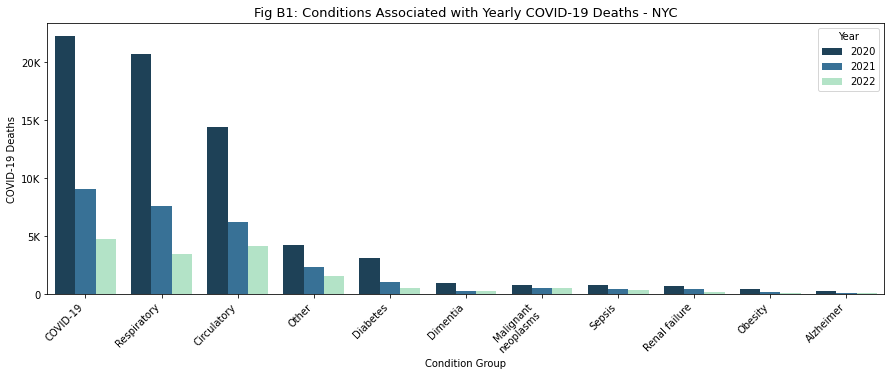

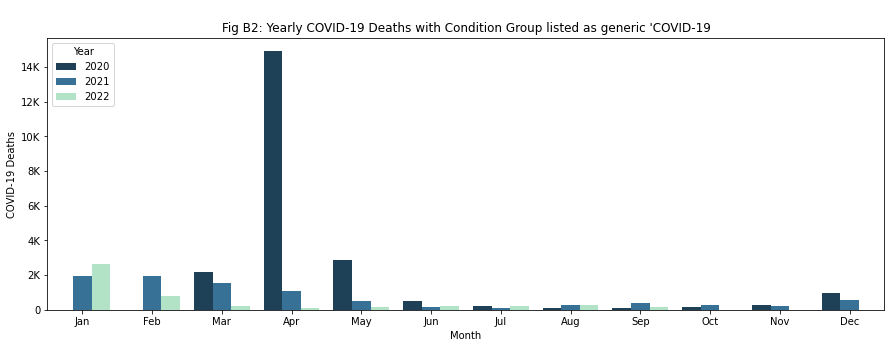

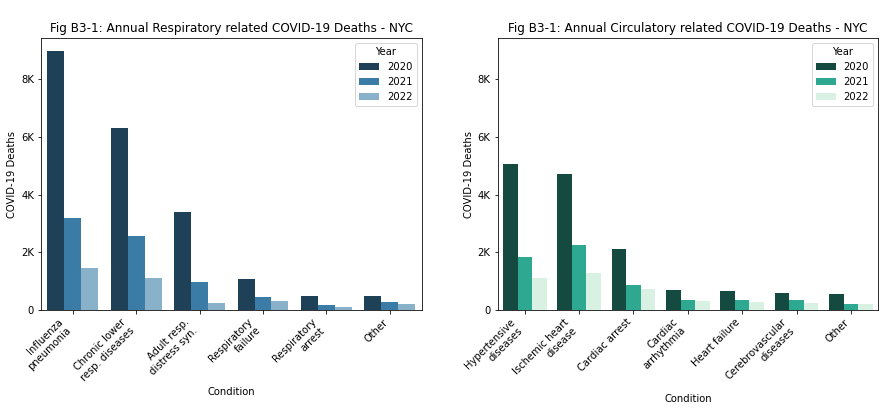

In [7]:
##looking at aggregate annual values across all age groups
_ = conditions_df[(conditions_df["Group"] == "By Year") & (conditions_df["Age Group"] == "All Ages")]
_.sort_values(["COVID-19 Deaths","Year"], ascending = False, inplace = True)
_.head()


##aggregating over all the "conditions" within a "condition group"
df = _.groupby(["Condition Group","Year"]).agg({"COVID-19 Deaths" : np.sum}).reset_index() 
df.sort_values("COVID-19 Deaths", ascending = False,inplace = True)

plt.figure(figsize = (15,5))
colors = ["#154360","#2874A6","#ABEBC6"]
sns.barplot(x = "Condition Group", y = "COVID-19 Deaths", hue = "Year", data = df, palette = colors);
plt.title('Fig B1: Conditions Associated with Yearly COVID-19 Deaths - NYC', fontsize = 13);
plt.xticks(rotation =45, ha="right");

plt.gca().set_yticklabels(["0","5K","10K","15K","20K","25K"]);

df = conditions_df[(conditions_df["Group"] == "By Year") & (conditions_df["Age Group"] == "All Ages") & 
             ((conditions_df["Condition Group"] == "Circulatory") | (conditions_df["Condition Group"] == "Respiratory"))]
df.sort_values("COVID-19 Deaths", ascending = False, inplace = True)
plt.savefig("B1.png")
##-----------------------------------------------------------------------------------------------------------------









df = conditions_df[(conditions_df["Group"] == "By Month") & (conditions_df["Age Group"] == "All Ages") & 
              (conditions_df["Condition Group"] == "COVID-19")]
# df.head()

plt.figure(figsize = (15,5));
colors = ["#154360","#2874A6","#ABEBC6"];
sns.barplot(x="Month", y="COVID-19 Deaths", hue="Year", palette = colors,data= df)
plt.title("\nFig B2: Yearly COVID-19 Deaths with Condition Group listed as generic 'COVID-19")
plt.gca().set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]);
plt.gca().set_yticklabels(["0","2K","4K","6K","8K","10K","12K","14K"]);

plt.savefig("B2.png")
##---------------------------------------------------------------------------------------------------------------







df = conditions_df[(conditions_df["Group"] == "By Year") & (conditions_df["Age Group"] == "All Ages") & 
             ((conditions_df["Condition Group"] == "Circulatory") | (conditions_df["Condition Group"] == "Respiratory"))]
df.sort_values("COVID-19 Deaths", ascending = False, inplace = True)


plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
colors = ["#154360","#2980B9","#7FB3D5"]
sns.barplot(x="Condition", y="COVID-19 Deaths", hue = "Year", palette = colors, 
                    data= df[df["Condition Group"] == "Respiratory"])
plt.title('\nFig B3-1: Annual Respiratory related COVID-19 Deaths - NYC');
plt.gca().set_xticklabels(['Influenza\npneumonia', 'Chronic lower\nresp. diseases','Adult resp.\ndistress syn.',
                       'Respiratory\nfailure','Respiratory\narrest', 'Other']);
plt.gca().set_yticklabels(["0","2K","4K","6K","8K"]);
plt.xticks(rotation =45, ha="right");


plt.subplot(1,2,2, sharey = plt.subplot(1,2,1))
colors = ["#0B5345","#1ABC9C","#D5F5E3"]
# sns.barplot(x="Condition", y="COVID-19 Deaths", hue = "Year", palette = colors,
#                     data= df[df["Condition Group"] == "Circulatory"])
sns.barplot(x="Condition", y="COVID-19 Deaths", hue = "Year", palette = colors,
                    data= df[df["Condition Group"] == "Circulatory"])
plt.title('\nFig B3-1: Annual Circulatory related COVID-19 Deaths - NYC');
plt.gca().set_xticklabels(['Hypertensive\ndiseases','Ischemic heart\ndisease', 'Cardiac arrest', 'Cardiac\narrhythmia',
                       'Heart failure', 'Cerebrovascular\ndiseases',"Other"]);
plt.gca().set_yticklabels(["0","2K","4K","6K","8K"]);
plt.xticks(rotation =45, ha="right");
plt.savefig("B3.png")

### <center> Observations </center>
There appear to be three main Conditions associated with COVID-19 related deaths in NYC - a generic "COVID-19" condition, as well as  Respiratory and Circulatory related conditions

<b>"COVID-19" Condition</b>: This group indicates those individuals where further information on underlying conditions does not exist or is unavailable (per dataset owners at the CDC). Based on this response I would expect a majority of such cases to be observed at the initial stages of the pandemic when not much was known about the virus. Further visual exploration revealed the same in the data; a vast majority of death in the "COVID-19" Condition Group were in April 2020

<b>"Respiratory" and "Circulatory" Conditions</b>: The primary conditions associated with COVID-19 deaths in this period appear to be respiratory and circulatory. Given the nature of this virus, the concentration in respiratory conditions is to be expected but its interesting to see a sizeable number of deaths associated with circulatory conditions.

Further details on the underlying subconditions for each group are also shown below:

* For the Respiratory group, most individuals who died suffered from Influenza & Pneumonia, followed by Respiratory Failure and Adult Respiratory Distress Syndrome.
* For the Circulatory group, most individuals who died suffered from Hypertensive disease, followed by Cardiac Arrest and Ischemic Heart Disease.

These trends do not change from 2020 to 2022 but, as expected, the number of deaths reduced over time.

<!-- ##### <center> Part C: Analysis of COVID-19 Deaths by Age Group</center>
We know from various news media<sup>[3](https://apnews.com/article/how-long-covid-19-illness-last-476754619ef76504abd1d7722b4b50a6)</sup> that COVID-19 impacted older individuals more severely, and so, we would expect to see a larger proportion of older individuals in our population. 

##### Observation:
This is consistent with what we see from the data; in Table 4 below, we can see that a majority of the COVID-19 related deaths in our sample are in the 65+ age group. -->

In [8]:
# def age(x):
#     if x == "0-24":
#         return "0-24"
#     elif x in ["25-34","35-44"]:
#         return "25-44"
#     elif x in ["45-54","55-64"]:
#         return "45-64"
#     else:
#         return "65+"
    
# conditions_df = conditions_df[(conditions_df["Group"] == "By Total") & 
#               (conditions_df["Age Group"] != "All Ages") & (conditions_df["Age Group"] != "Not stated") &
#               ((conditions_df["Condition Group"] == "COVID-19") | (conditions_df["Condition Group"] == "Circulatory") |
#               (conditions_df["Condition Group"] == "Respiratory"))]
# conditions_df["Age"] = conditions_df["Age Group"].apply(lambda x: age(x))

# df = conditions_df.groupby(["Condition Group","Age"]).agg({"COVID-19 Deaths":np.sum}).reset_index()


# plt.figure(figsize = (10,5));
# colors = ["#154360","#2874A6","#ABEBC6"];
# sns.barplot(x="Condition Group", y="COVID-19 Deaths", hue="Age", palette = colors, data= df)
# plt.title('Fig C: Total COVID-19 Deaths By Condition and Age Group \n 2020 - June2022');
# # plt.xticks(rotation =45, ha="right");

### References
* https://www.cdc.gov/
* https://en.wikipedia.org/wiki/Centers_for_Disease_Control_and_Prevention 
* https://apnews.com/article/how-long-covid-19-illness-last-476754619ef76504abd1d7722b4b50a6
* https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007007
* https://covariants.org
* https://www.nytimes.com/interactive/2021/health/coronavirus-variant-tracker.html
* https://www.cdc.gov/coronavirus/2019-ncov/variants/variant-classifications.html
* https://www.cnbc.com/2020/03/07/new-york-governor-andrew-cuomo-declares-state-of-emergency-over-coronavirus-outbreak.html
* https://www.governor.ny.gov/news/governor-cuomo-issues-guidance-essential-services-under-new-york-state-pause-executive-order#:~:text=Cuomo%20announced%20he%20is%20signing,8PM%20on%20Sunday%2C%20March%2022
* https://www.governor.ny.gov/news/amid-ongoing-covid-19-pandemic-governor-cuomo-issues-executive-order-requiring-all-people-new#:~:text=Amid%20the%20ongoing%20COVID%2D19,such%20as%20on%20public%20transportation.
* https://en.wikipedia.org/wiki/COVID-19_pandemic_in_New_York_City
* https://web.archive.org/web/20200309082540/https://www.nytimes.com/2020/03/07/nyregion/coronavirus-new-york-queens.html
* https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986